In [1]:
# !pip install tensorflow==1.15.0
# !pip install h5py==2.10.0 --force-reinstall
# !pip install -U numpy==1.19.5

In [3]:
import numpy as np
import pandas as pd
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl

In [4]:
randomState = 42
np.random.seed(randomState)
tf.set_random_seed(randomState)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Depth 5cm

In [6]:
raw5 = pd.read_csv('/content/gdrive/MyDrive/SoilMoisture/Data/c_5_data_soil_5.csv')
df5 = raw5.copy()

df5 = df5.rename(columns={'In-Situ':'InSitu'})

def replace_missing(attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df5['NDVI'])
replace_missing(df5['EVI'])
replace_missing(df5['LSTDay'])
replace_missing(df5['LSTNight'])

df5 = df5.dropna()
df5.isnull().sum()

Precip       0
NDVI         0
EVI          0
GPP          0
LSTDay       0
LSTNight     0
Elevation    0
RZSM         0
SURFSM       0
Clay         0
Sand         0
Silt         0
BD           0
InSitu       0
dtype: int64

In [7]:
df5['group'] = df5['Sand'].ne(df5['Sand'].shift()).cumsum()
df5 = df5.groupby('group')
dfs = []
for name, data in df5:
    dfs.append(data)

In [8]:
train_dataset = pd.DataFrame()
val_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

for df in dfs:
    df.pop('group')
    train_size = int(len(df)*0.8)
    val_size = int(len(df)*0.9)
    train, val, test = df.iloc[:train_size], df.iloc[train_size:val_size], df.iloc[val_size:]
    train_dataset = train_dataset.append(train)
    val_dataset = val_dataset.append(val)
    test_dataset = test_dataset.append(test)

In [9]:
# Split X
X_train = train_dataset.drop('InSitu', axis = 1)
X_val = val_dataset.drop('InSitu', axis = 1)
X_test = test_dataset.drop('InSitu', axis = 1)

# Split y
y_train = train_dataset.loc[:,['InSitu']]
y_val = val_dataset.loc[:,['InSitu']]
y_test = test_dataset.loc[:,['InSitu']]

In [10]:
# Fit the scaler using available training data
input_scaler = StandardScaler().fit(X_train)

# Apply the scaler to training data
x_train = input_scaler.transform(X_train)
x_val = input_scaler.transform(X_val)
x_test = input_scaler.transform(X_test)

x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.float32)

x_val = np.array(x_val, np.float32)
y_val = np.array(y_val, np.float32)

x_test = np.array(x_test, np.float32)
y_test = np.array(y_test, np.float32)

y_train = y_train.reshape((y_train.size, 1))
y_val = y_val.reshape((y_val.size, 1))
y_test = y_test.reshape((y_test.size, 1))

In [11]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys= [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])        
    return np.array(Xs), np.array(ys)

TIME_STEPS = 15

In [12]:
x_test, y_test = create_dataset(x_test, y_test, TIME_STEPS)
x_train, y_train = create_dataset(x_train, y_train, TIME_STEPS)
x_val, y_val = create_dataset(x_val, y_val, TIME_STEPS)
validation_data = (x_val, y_val)

In [13]:
model = load_model('/content/gdrive/MyDrive/SoilMoisture/GRU_Models/GRU_5_best_model.h5')
# optimizer = Adam(lr=learning_rate)
# model.summary()
# model.compile(optimizer=optimizer, loss='MSE', metrics=[tf.keras.metrics.MeanSquaredError()])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', restore_best_weights=True)

histories = model.fit(x_train, y_train, validation_data=(x_val,y_val), callbacks=[monitor],verbose=2,epochs=100)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 43960 samples, validate on 5479 samples
Epoch 1/100
43960/43960 - 40s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2/100
43960/43960 - 38s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 3/100
43960/43960 - 38s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 4/100
43960/43960 - 38s - loss: 0.0016

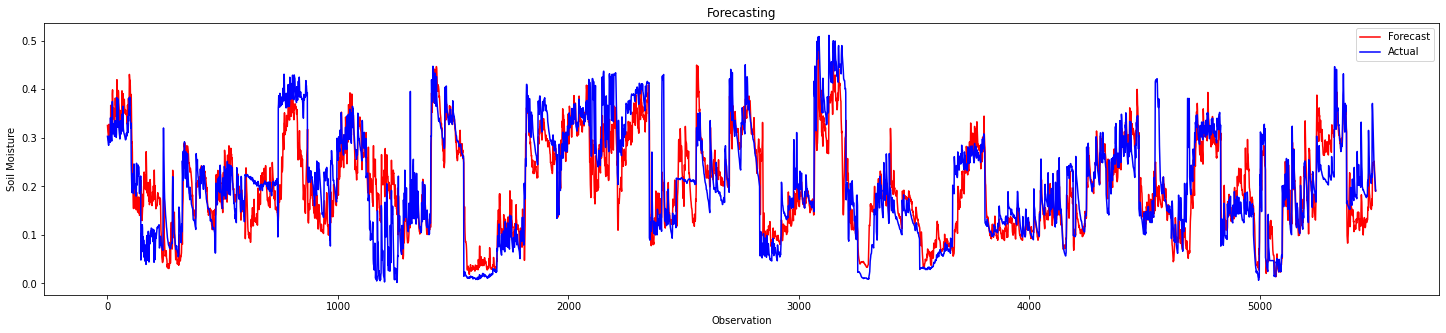

In [14]:
y_pred = model.predict(x_test)

plt.figure(figsize=(25, 5))
plt.plot(y_pred, 'r')
plt.plot(y_test, 'b' )
plt.title('Forecasting')
plt.ylabel('Soil Moisture')
plt.xlabel('Observation')
plt.legend(['Forecast', 'Actual'], loc='upper right')
plt.savefig('/content/gdrive/MyDrive/SoilMoisture/Forecast/GRU_c5_5.png', dpi=400)
plt.show()

#Depth 10cm

In [15]:
raw10 = pd.read_csv('/content/gdrive/MyDrive/SoilMoisture/Data/c_5_data_soil_10.csv')
df10 = raw10.copy()

df10 = df10.rename(columns={'In-Situ':'InSitu'})

def replace_missing(attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df10['NDVI'])
replace_missing(df10['EVI'])
replace_missing(df10['LSTDay'])
replace_missing(df10['LSTNight'])

df10 = df10.dropna()
df10.isnull().sum()

Precip       0
NDVI         0
EVI          0
GPP          0
LSTDay       0
LSTNight     0
Elevation    0
RZSM         0
SURFSM       0
Clay         0
Sand         0
Silt         0
BD           0
InSitu       0
dtype: int64

In [16]:
df10['group'] = df10['Sand'].ne(df10['Sand'].shift()).cumsum()
df10 = df10.groupby('group')
dfs = []
for name, data in df10:
    dfs.append(data)

In [17]:
train_dataset = pd.DataFrame()
val_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

for df in dfs:
    df.pop('group')
    train_size = int(len(df)*0.8)
    val_size = int(len(df)*0.9)
    train, val, test = df.iloc[:train_size], df.iloc[train_size:val_size], df.iloc[val_size:]
    train_dataset = train_dataset.append(train)
    val_dataset = val_dataset.append(val)
    test_dataset = test_dataset.append(test)

In [18]:
# Split X
X_train = train_dataset.drop('InSitu', axis = 1)
X_val = val_dataset.drop('InSitu', axis = 1)
X_test = test_dataset.drop('InSitu', axis = 1)

# Split y
y_train = train_dataset.loc[:,['InSitu']]
y_val = val_dataset.loc[:,['InSitu']]
y_test = test_dataset.loc[:,['InSitu']]

In [19]:
# Fit the scaler using available training data
input_scaler = StandardScaler().fit(X_train)

# Apply the scaler to training data
x_train = input_scaler.transform(X_train)
x_val = input_scaler.transform(X_val)
x_test = input_scaler.transform(X_test)

x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.float32)

x_val = np.array(x_val, np.float32)
y_val = np.array(y_val, np.float32)

x_test = np.array(x_test, np.float32)
y_test = np.array(y_test, np.float32)

y_train = y_train.reshape((y_train.size, 1))
y_val = y_val.reshape((y_val.size, 1))
y_test = y_test.reshape((y_test.size, 1))

In [20]:
x_test, y_test = create_dataset(x_test, y_test, TIME_STEPS)
x_train, y_train = create_dataset(x_train, y_train, TIME_STEPS)
x_val, y_val = create_dataset(x_val, y_val, TIME_STEPS)
validation_data = (x_val, y_val)

In [21]:
model = load_model('/content/gdrive/MyDrive/SoilMoisture/GRU_Models/GRU_10_best_model.h5')
# optimizer = Adam(lr=learning_rate)
# model.summary()
# model.compile(optimizer=optimizer, loss='MSE', metrics=[tf.keras.metrics.MeanSquaredError()])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', restore_best_weights=True)

histories = model.fit(x_train, y_train, validation_data=(x_val,y_val), callbacks=[monitor],verbose=2,epochs=100)

Train on 43082 samples, validate on 5368 samples
Epoch 1/100
43082/43082 - 57s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 2/100
43082/43082 - 55s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/100
43082/43082 - 55s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 4/100
43082/43082 - 55s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 5/100
43082/43082 - 55s - loss: 9.6978e-04 - mean_squared_error: 9.6978e-04 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 6/100
43082/43082 - 55s - loss: 9.2696e-04 - mean_squared_error: 9.2696e-04 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 7/100
43082/43082 - 55s - loss: 8.7286e-04 - mean_squared_error: 8.7286e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 8/100
43082/43082 - 55s - loss: 8.3162e

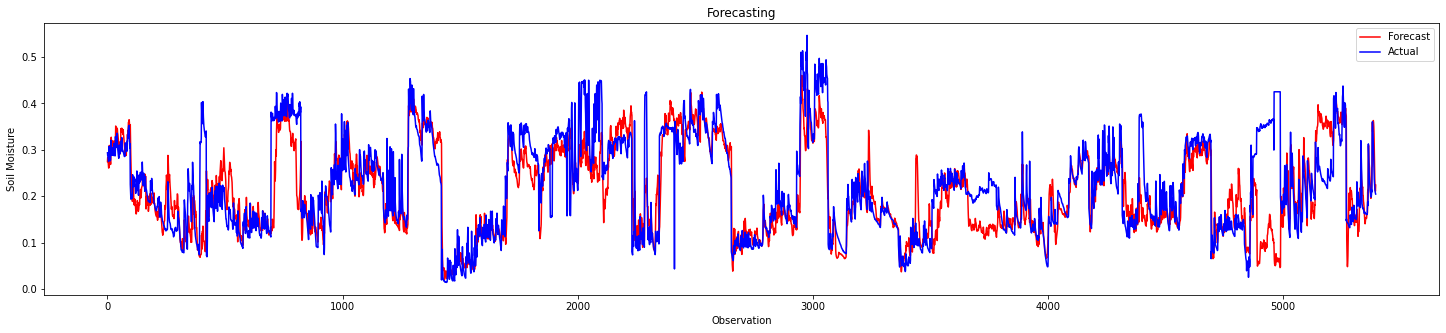

In [22]:
y_pred = model.predict(x_test)

plt.figure(figsize=(25, 5))
plt.plot(y_pred, 'r')
plt.plot(y_test, 'b' )
plt.title('Forecasting')
plt.ylabel('Soil Moisture')
plt.xlabel('Observation')
plt.legend(['Forecast', 'Actual'], loc='upper right')
plt.savefig('/content/gdrive/MyDrive/SoilMoisture/Forecast/GRU_c5_10.png', dpi=400)
plt.show()

#Depth 20cm

In [23]:
raw20 = pd.read_csv('/content/gdrive/MyDrive/SoilMoisture/Data/c_5_data_soil_20.csv')
df20 = raw20.copy()

df20 = df20.rename(columns={'In-Situ':'InSitu'})

def replace_missing(attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df20['NDVI'])
replace_missing(df20['EVI'])
replace_missing(df20['LSTDay'])
replace_missing(df20['LSTNight'])

df20 = df20.dropna()
df20.isnull().sum()

Precip       0
NDVI         0
EVI          0
GPP          0
LSTDay       0
LSTNight     0
Elevation    0
RZSM         0
SURFSM       0
Clay         0
Sand         0
Silt         0
BD           0
InSitu       0
dtype: int64

In [24]:
df20['group'] = df20['Sand'].ne(df20['Sand'].shift()).cumsum()
df20 = df20.groupby('group')
dfs = []
for name, data in df20:
    dfs.append(data)

In [25]:
train_dataset = pd.DataFrame()
val_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

for df in dfs:
    df.pop('group')
    train_size = int(len(df)*0.8)
    val_size = int(len(df)*0.9)
    train, val, test = df.iloc[:train_size], df.iloc[train_size:val_size], df.iloc[val_size:]
    train_dataset = train_dataset.append(train)
    val_dataset = val_dataset.append(val)
    test_dataset = test_dataset.append(test)

In [26]:
# Split X
X_train = train_dataset.drop('InSitu', axis = 1)
X_val = val_dataset.drop('InSitu', axis = 1)
X_test = test_dataset.drop('InSitu', axis = 1)

# Split y
y_train = train_dataset.loc[:,['InSitu']]
y_val = val_dataset.loc[:,['InSitu']]
y_test = test_dataset.loc[:,['InSitu']]

In [27]:
# Fit the scaler using available training data
input_scaler = StandardScaler().fit(X_train)

# Apply the scaler to training data
x_train = input_scaler.transform(X_train)
x_val = input_scaler.transform(X_val)
x_test = input_scaler.transform(X_test)

x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.float32)

x_val = np.array(x_val, np.float32)
y_val = np.array(y_val, np.float32)

x_test = np.array(x_test, np.float32)
y_test = np.array(y_test, np.float32)

y_train = y_train.reshape((y_train.size, 1))
y_val = y_val.reshape((y_val.size, 1))
y_test = y_test.reshape((y_test.size, 1))

In [28]:
x_test, y_test = create_dataset(x_test, y_test, TIME_STEPS)
x_train, y_train = create_dataset(x_train, y_train, TIME_STEPS)
x_val, y_val = create_dataset(x_val, y_val, TIME_STEPS)
validation_data = (x_val, y_val)

In [29]:
model = load_model('/content/gdrive/MyDrive/SoilMoisture/GRU_Models/GRU_20_best_model.h5')
# optimizer = Adam(lr=learning_rate)
# model.summary()
# model.compile(optimizer=optimizer, loss='MSE', metrics=[tf.keras.metrics.MeanSquaredError()])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', restore_best_weights=True)

histories = model.fit(x_train, y_train, validation_data=(x_val,y_val), callbacks=[monitor],verbose=2,epochs=100)

Train on 39338 samples, validate on 4903 samples
Epoch 1/100
39338/39338 - 35s - loss: 9.1793e-04 - mean_squared_error: 9.1793e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2/100
39338/39338 - 34s - loss: 7.5870e-04 - mean_squared_error: 7.5870e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 3/100
39338/39338 - 34s - loss: 6.7978e-04 - mean_squared_error: 6.7978e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 4/100
39338/39338 - 34s - loss: 6.4199e-04 - mean_squared_error: 6.4199e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 5/100
39338/39338 - 34s - loss: 5.8251e-04 - mean_squared_error: 5.8251e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 6/100
39338/39338 - 34s - loss: 5.4637e-04 - mean_squared_error: 5.4637e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 7/100
39338/39338 - 33s - loss: 5.3082e-04 - mean_squared_error: 5.3082e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 8/100
3

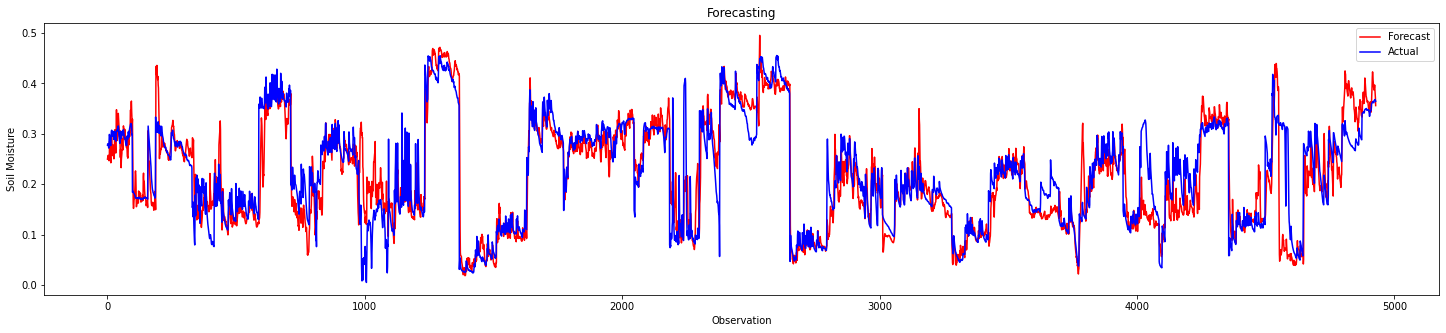

In [30]:
y_pred = model.predict(x_test)

plt.figure(figsize=(25, 5))
plt.plot(y_pred, 'r')
plt.plot(y_test, 'b' )
plt.title('Forecasting')
plt.ylabel('Soil Moisture')
plt.xlabel('Observation')
plt.legend(['Forecast', 'Actual'], loc='upper right')
plt.savefig('/content/gdrive/MyDrive/SoilMoisture/Forecast/GRU_c5_20.png', dpi=400)
plt.show()

#Depth 50cm

In [31]:
raw50 = pd.read_csv('/content/gdrive/MyDrive/SoilMoisture/Data/c_5_data_soil_50.csv')
df50 = raw50.copy()

df50 = df50.rename(columns={'In-Situ':'InSitu'})

def replace_missing(attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df50['NDVI'])
replace_missing(df50['EVI'])
replace_missing(df50['LSTDay'])
replace_missing(df50['LSTNight'])

df50 = df50.dropna()
df50.isnull().sum()

Precip       0
NDVI         0
EVI          0
GPP          0
LSTDay       0
LSTNight     0
Elevation    0
RZSM         0
SURFSM       0
Clay         0
Sand         0
Silt         0
BD           0
InSitu       0
dtype: int64

In [32]:
df50['group'] = df50['Sand'].ne(df50['Sand'].shift()).cumsum()
df50 = df50.groupby('group')
dfs = []
for name, data in df50:
    dfs.append(data)

In [33]:
train_dataset = pd.DataFrame()
val_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

for df in dfs:
    df.pop('group')
    train_size = int(len(df)*0.8)
    val_size = int(len(df)*0.9)
    train, val, test = df.iloc[:train_size], df.iloc[train_size:val_size], df.iloc[val_size:]
    train_dataset = train_dataset.append(train)
    val_dataset = val_dataset.append(val)
    test_dataset = test_dataset.append(test)

In [34]:
# Split X
X_train = train_dataset.drop('InSitu', axis = 1)
X_val = val_dataset.drop('InSitu', axis = 1)
X_test = test_dataset.drop('InSitu', axis = 1)

# Split y
y_train = train_dataset.loc[:,['InSitu']]
y_val = val_dataset.loc[:,['InSitu']]
y_test = test_dataset.loc[:,['InSitu']]

In [35]:
# Fit the scaler using available training data
input_scaler = StandardScaler().fit(X_train)

# Apply the scaler to training data
x_train = input_scaler.transform(X_train)
x_val = input_scaler.transform(X_val)
x_test = input_scaler.transform(X_test)

x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.float32)

x_val = np.array(x_val, np.float32)
y_val = np.array(y_val, np.float32)

x_test = np.array(x_test, np.float32)
y_test = np.array(y_test, np.float32)

y_train = y_train.reshape((y_train.size, 1))
y_val = y_val.reshape((y_val.size, 1))
y_test = y_test.reshape((y_test.size, 1))

In [36]:
x_test, y_test = create_dataset(x_test, y_test, TIME_STEPS)
x_train, y_train = create_dataset(x_train, y_train, TIME_STEPS)
x_val, y_val = create_dataset(x_val, y_val, TIME_STEPS)
validation_data = (x_val, y_val)

In [37]:
model = load_model('/content/gdrive/MyDrive/SoilMoisture/GRU_Models/GRU_50_best_model.h5')
# optimizer = Adam(lr=learning_rate)
# model.summary()
# model.compile(optimizer=optimizer, loss='MSE', metrics=[tf.keras.metrics.MeanSquaredError()])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', restore_best_weights=True)

histories = model.fit(x_train, y_train, validation_data=(x_val,y_val), callbacks=[monitor],verbose=2,epochs=100)

Train on 36602 samples, validate on 4562 samples
Epoch 1/100
36602/36602 - 33s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2/100
36602/36602 - 32s - loss: 8.2968e-04 - mean_squared_error: 8.2968e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 3/100
36602/36602 - 31s - loss: 7.0715e-04 - mean_squared_error: 7.0715e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 4/100
36602/36602 - 32s - loss: 5.9822e-04 - mean_squared_error: 5.9822e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 5/100
36602/36602 - 31s - loss: 5.7226e-04 - mean_squared_error: 5.7226e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 6/100
36602/36602 - 31s - loss: 5.8577e-04 - mean_squared_error: 5.8577e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 7/100
36602/36602 - 31s - loss: 5.3472e-04 - mean_squared_error: 5.3472e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 8/100
36602/366

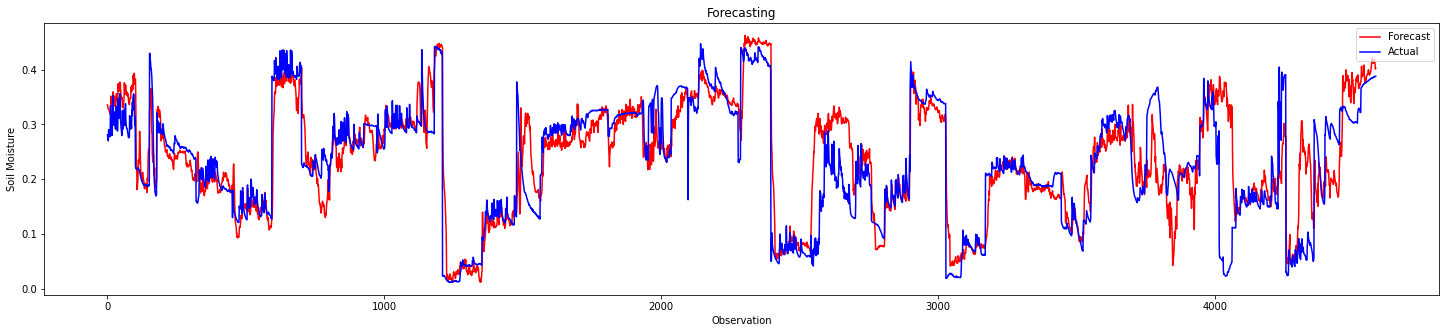

In [38]:
y_pred = model.predict(x_test)

plt.figure(figsize=(25, 5))
plt.plot(y_pred, 'r')
plt.plot(y_test, 'b' )
plt.title('Forecasting')
plt.ylabel('Soil Moisture')
plt.xlabel('Observation')
plt.legend(['Forecast', 'Actual'], loc='upper right')
plt.savefig('/content/gdrive/MyDrive/SoilMoisture/Forecast/GRU_c5_50.png', dpi=400)
plt.show()

#Depth 100cm


In [39]:
raw100 = pd.read_csv('/content/gdrive/MyDrive/SoilMoisture/Data/c_5_data_soil_100.csv')
df100 = raw100.copy()

df100 = df100.rename(columns={'In-Situ':'InSitu'})

def replace_missing(attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df100['NDVI'])
replace_missing(df100['EVI'])
replace_missing(df100['LSTDay'])
replace_missing(df100['LSTNight'])

df100 = df100.dropna()
df100.isnull().sum()

Precip       0
NDVI         0
EVI          0
GPP          0
LSTDay       0
LSTNight     0
Elevation    0
RZSM         0
SURFSM       0
Clay         0
Sand         0
Silt         0
BD           0
InSitu       0
dtype: int64

In [40]:
df100['group'] = df100['Sand'].ne(df100['Sand'].shift()).cumsum()
df100 = df100.groupby('group')
dfs = []
for name, data in df100:
    dfs.append(data)

In [41]:
train_dataset = pd.DataFrame()
val_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

for df in dfs:
    df.pop('group')
    train_size = int(len(df)*0.8)
    val_size = int(len(df)*0.9)
    train, val, test = df.iloc[:train_size], df.iloc[train_size:val_size], df.iloc[val_size:]
    train_dataset = train_dataset.append(train)
    val_dataset = val_dataset.append(val)
    test_dataset = test_dataset.append(test)

In [42]:
# Split X
X_train = train_dataset.drop('InSitu', axis = 1)
X_val = val_dataset.drop('InSitu', axis = 1)
X_test = test_dataset.drop('InSitu', axis = 1)

# Split y
y_train = train_dataset.loc[:,['InSitu']]
y_val = val_dataset.loc[:,['InSitu']]
y_test = test_dataset.loc[:,['InSitu']]

In [43]:
# Fit the scaler using available training data
input_scaler = StandardScaler().fit(X_train)

# Apply the scaler to training data
x_train = input_scaler.transform(X_train)
x_val = input_scaler.transform(X_val)
x_test = input_scaler.transform(X_test)

x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.float32)

x_val = np.array(x_val, np.float32)
y_val = np.array(y_val, np.float32)

x_test = np.array(x_test, np.float32)
y_test = np.array(y_test, np.float32)

y_train = y_train.reshape((y_train.size, 1))
y_val = y_val.reshape((y_val.size, 1))
y_test = y_test.reshape((y_test.size, 1))

In [44]:
x_test, y_test = create_dataset(x_test, y_test, TIME_STEPS)
x_train, y_train = create_dataset(x_train, y_train, TIME_STEPS)
x_val, y_val = create_dataset(x_val, y_val, TIME_STEPS)
validation_data = (x_val, y_val)

In [45]:
model = load_model('/content/gdrive/MyDrive/SoilMoisture/GRU_Models/GRU_100_best_model.h5')
# optimizer = Adam(lr=learning_rate)
# model.summary()
# model.compile(optimizer=optimizer, loss='MSE', metrics=[tf.keras.metrics.MeanSquaredError()])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', restore_best_weights=True)

histories = model.fit(x_train, y_train, validation_data=(x_val,y_val), callbacks=[monitor],verbose=2,epochs=100)

Train on 33969 samples, validate on 4231 samples
Epoch 1/100
33969/33969 - 45s - loss: 0.0779 - mean_squared_error: 0.0779 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 2/100
33969/33969 - 43s - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 3/100
33969/33969 - 43s - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 4/100
33969/33969 - 43s - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 5/100
33969/33969 - 43s - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 6/100
33969/33969 - 43s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 7/100
33969/33969 - 43s - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 8/100
33969/33969 - 43s - loss: 0.0070 - mean_squared_error: 0.

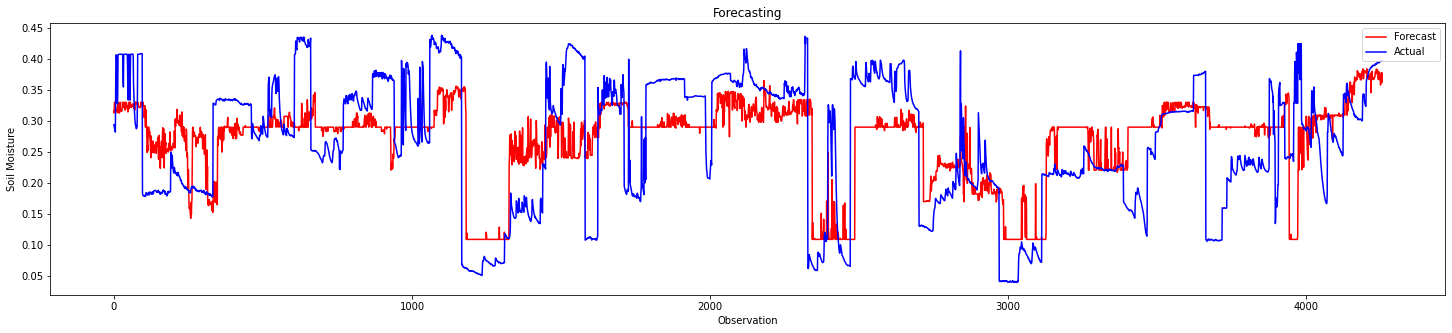

In [46]:
y_pred = model.predict(x_test)

plt.figure(figsize=(25, 5))
plt.plot(y_pred, 'r')
plt.plot(y_test, 'b' )
plt.title('Forecasting')
plt.ylabel('Soil Moisture')
plt.xlabel('Observation')
plt.legend(['Forecast', 'Actual'], loc='upper right')
plt.savefig('/content/gdrive/MyDrive/SoilMoisture/Forecast/GRU_c5_100.png', dpi=400)
plt.show()